## Clean Version of my "Where is Waldo?" Contribution - ACG  

This Notebook intends to create a clean and clearer version of the work done in the previous week

In [43]:
# First, we need to import the relevant packages

# Pillow package to handle images. Mostly to properly save the manipulated images.
from PIL import Image
from PIL import ImageFilter

# Import OpenCV packege. Used mostly for some basic analysis
import cv2

# Import os packages for file management
import os

# Random package is useful to sample and reduce the Non-Waldo set
import random

# From scikit learn we need to properly split our dataset
# as well as to perform Principal Component Analysis
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

# Other useful and common packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Inline plotting
%matplotlib inline

#### We define some useful functions, namely:
1. A function corner_cut which takes an image, coordinates and lengths, and returns a section of the image. Important Note: Lengths have to be always smaller than the size of the image (Check not implemented).
2. A similar function, center cut. The difference is how the cut is extracted. Center cut uses the coordinates as the center of the image. Corner cut uses the coordinates as the upper left corner.

In [2]:
# corner_cut - Extracts a subimage from an image img, using coords to define the center of the image.

def corner_cut(img, coords, pixh, pixw):
    
    #define frame for the cut
    x = [coords[0], coords[0] + pixw]
    y = [coords[1], coords[1] + pixh]

    #check lower boundaries
    if x[0] < 0: x = [0,pixw]
    if y[0] < 0: y = [0,pixh]

    #check upper boundaries
    if x[1] > img.shape[0]: x = [img.shape[0] - pixw,img.shape[0] - 1]
    if y[1] > img.shape[1]: y = [img.shape[1] - pixh,img.shape[1] - 1]
    
    return img[x[0]:x[1], y[0]:y[1],:]

In [3]:
# center_cut - Extracts a subimage from an image img, using coords to define the upper left corner of the image.

def center_cut(img, coords, pixh, pixw):
    
    #define frame for the cut
    x = [coords[0] - pixw//2, coords[0] + pixw//2]
    y = [coords[1] - pixh//2, coords[1] + pixh//2]

    #check lower boundaries
    if x[0] < 0: x = [0,pixw]
    if y[0] < 0: y = [0,pixh]

    #check upper boundaries
    if x[1] > img.shape[0]: x = [img.shape[0] - pixw,img.shape[0] - 1]
    if y[1] > img.shape[1]: y = [img.shape[1] - pixh,img.shape[1] - 1]

    return img[x[0]:x[1], y[0]:y[1],:]

It should be noted that the coordinates are expected to be written according to the array rules for jpg files. That is, the first entry is a vertical distance from the upper left corner of the image, and the second entry is the horizontal distance.  

Other useful functions:
1. A function Dom_Channel that applies a mask that takes and image and returns a different image where a mask is applied to produce the dominant channel for each pixel.
2. RandShift. Given a coordinate and lengths, returns a randomly shifted around a Manhattan distance of half the image lengths (can be expanded, but there is no clear reason to do that)
3. Redpct. A function that returns the fraction of red dominant channel in a given image. Note, this already includes the function Dom_Channel, so the input image is the original one.

In [4]:
# Dom_Channel - Returns an image with the dominant color channel from a given image
def Dom_Channel(img_org):
    img_dom_Channel = np.argmax(img_org, axis = 2)
    img_dom = np.zeros_like(img_org)
    a,b,_ = img_org.shape
    for i in range(a):
        for j in range(b):
            img_dom[i,j,img_dom_Channel[i,j]] = 255
    return img_dom

In [5]:
def RandShift(coord, pixh, pixw):
    rand_array = np.random.randint(2, size=10)
    y = coord[0] + np.random.randint(pixh//2) - pixh//4
    x = coord[1] + np.random.randint(pixw//2) - pixw//4
    return [y,x]

In [153]:
def Redpct(image):
    a,b,_ = image.shape
    Dom_image = Dom_Channel(image)
    return(np.count_nonzero(Dom_image[:,:,0])/(a*b))

def Greenpct(image):
    a,b,_ = image.shape
    Dom_image = Dom_Channel(image)
    return(np.count_nonzero(Dom_image[:,:,1])/(a*b))

def Bluepct(image):
    a,b,_ = image.shape
    Dom_image = Dom_Channel(image)
    return(np.count_nonzero(Dom_image[:,:,2])/(a*b))

### Red Channel Waldo Testing

Using a small subset of files where the coordinates for Waldo are known, the percentage or red as domminant channel is investigated.

In [7]:
# Note. It might be posible and even desirable to implement a dictionary in order to handle this part
Filenames = ["W1","W7","W13B","W19","W25","W31","W37","W43"]
Wal_coord = [[508, 694], [948, 802], [360, 1250],
            [615, 315], [1490, 2195], [1300, 2520],
            [1515, 445], [48, 1895]]
Walredpct = []
Waldo_train = []
W_coord = []
# Number of samples made from each Waldo
Waldo_Samples = 50

# Directories
#Work_dir = os.getcwd()
#Waldo_dir = "Waldo_set"
#Full_dir = os.path.join(Work_dir, Waldo_dir)


Image W1
Fraction of the Full image 0.8087045988209433
Maximum Fraction of Red Channel 0.806396484375
Minimum Fraction of Red Channel 0.607177734375
Number of elements analyzed 50
<class 'list'> 



Image W7
Fraction of the Full image 0.5768650987785428
Maximum Fraction of Red Channel 0.876220703125
Minimum Fraction of Red Channel 0.708740234375
Number of elements analyzed 50
<class 'list'> 



Image W13B
Fraction of the Full image 0.6442254489613446
Maximum Fraction of Red Channel 0.645263671875
Minimum Fraction of Red Channel 0.52978515625
Number of elements analyzed 50
<class 'list'> 



Image W19
Fraction of the Full image 0.29786060474537035
Maximum Fraction of Red Channel 0.32861328125
Minimum Fraction of Red Channel 0.202392578125
Number of elements analyzed 50
<class 'list'> 



Image W25
Fraction of the Full image 0.49852908069825314
Maximum Fraction of Red Channel 0.750244140625
Minimum Fraction of Red Channel 0.476806640625
Number of elements analyzed 50
<class 'list'> 



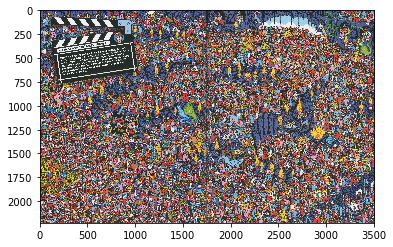

Image W31
Fraction of the Full image 0.4701728886855256
Maximum Fraction of Red Channel 0.782958984375
Minimum Fraction of Red Channel 0.570556640625
Number of elements analyzed 50
<class 'list'> 



Image W37
Fraction of the Full image 0.660546187081978
Maximum Fraction of Red Channel 0.96484375
Minimum Fraction of Red Channel 0.840087890625
Number of elements analyzed 50
<class 'list'> 



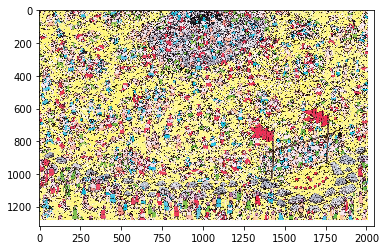

Image W43
Fraction of the Full image 0.823138825991085
Maximum Fraction of Red Channel 0.94189453125
Minimum Fraction of Red Channel 0.7998046875
Number of elements analyzed 50
<class 'list'> 



In [8]:
# Here we make an array of possible Waldo features, as well as the dominant channel and percentage of red in the image
for im in range(len(Filenames)):
    image = plt.imread(Filenames[im] + '.jpg')
    Pct_test = []
    # Ya con el archivo abierto, necesitamos extraer a Waldo y crear copias
    plt.imshow(image)
    plt.show()
    for wi in range(Waldo_Samples):
    
        W_shift = RandShift(Wal_coord[im], 64, 64)
        W_cut = corner_cut(image, W_shift, 64, 64)
        W_red = Dom_Channel(W_cut)
        
        Waldo_train.append(W_cut)
        W_coord.append(W_shift)
        Walredpct.append(Redpct(W_cut))
        Pct_test.append(Redpct(W_cut))

    print("Image " + Filenames[im])
    print("Fraction of the Full image", Redpct(image))
    print("Maximum Fraction of Red Channel", max(Pct_test))
    print("Minimum Fraction of Red Channel", min(Pct_test))
    print("Number of elements analyzed", len(Pct_test))
    print(type(Pct_test),'\n')

What is clear from the previous exercise is that there are two different Waldos that can be found. One is the head, the other one is the body.  
With the previous cell we have now a set of 400 Waldo entries (saved as Waldo_train). We have now to construct the Not Waldo set. Therefore we need to divide the images in a couple of ways.  

NOTE: It might be better to convert to numpy arrays instead of using lists

In [9]:
#pct_np = np.array(Pct_test)
#pct_np.min()

In [10]:
# Here we create the Non-Waldo set. For this we slice twice each of the images, and remove the frames 
# within certain distance from Waldo

# Empty Not Waldo List
NW_train = []
NW_coord = []
h_pix = 64
w_pix = 64

for im in range(len(Filenames)):
    image = plt.imread(Filenames[im] + '.jpg')
    
    # We extract the image size
    size_y, size_x,_ = image.shape
    h_max, w_max = size_y//h_pix + 1, size_x//w_pix + 1
    
    for i in range(h_max):
        for j in range(w_max):
            coords = [i*h_pix, j*w_pix]
            NW_cut = corner_cut(image, coords, h_pix, w_pix)
            Mh_dist = np.abs(coords[0] - Wal_coord[im][0]) + np.abs(coords[1] - Wal_coord[im][1])
            
            if Mh_dist > 64:
                NW_train.append(NW_cut)
                NW_coord.append([coords, Filenames[im]])

            coords = [i*h_pix + h_pix//2, j*w_pix + w_pix//2]
            NW_cut = corner_cut(image, coords, h_pix, w_pix)
            Mh_dist = np.abs(coords[0] - Wal_coord[im][0]) + np.abs(coords[1] - Wal_coord[im][1])
            
            if Mh_dist > 64:
                NW_train.append(NW_cut)
                NW_coord.append([coords, Filenames[im]])
            
# NOTE: Some other shifts can be used to produce a bigger set. Not sure it would be useful

### Now both Waldo and Not Waldo sets are created. 
We can save each set in a given folder, for later inspection.  
It is also possible to try a classification scheme on them immediately.
So, here we save each training set, Waldo and NW into corresponding folders.  
It might be noticed that, as we have pointed out, there are two different Waldos to be found: face, and full. It might be interesting to create classifiers for both cases, which would require us to redo all previous steps for two different sets of Waldos.

In [11]:
# Now, lets save the Waldos
# Directories
Work_dir = os.getcwd()
Waldo_dir = "Waldo_set"
Full_dir = os.path.join(Work_dir, Waldo_dir)

if not os.path.exists(Full_dir):
    os.mkdir(Full_dir)
    
for i,image in enumerate(Waldo_train):
    im_pil = Image.fromarray(image)
    im_pil.save(Full_dir + '\\' + Filenames[i//Waldo_Samples] + '-' + str(i%Waldo_Samples) + '.jpg')

In [12]:
# Now, lets save the Waldos
# Directories
Work_dir = os.getcwd()
Waldo_dir = "NW_set"
Full_dir = os.path.join(Work_dir, Waldo_dir)

if not os.path.exists(Full_dir):
    os.mkdir(Full_dir)
    
for i,image in enumerate(NW_train):
    im_pil = Image.fromarray(image)
    im_pil.save(Full_dir + '\\' + NW_coord[i][1] + '-' + str(NW_coord[i][0][0]) + '-' + str(NW_coord[i][0][1]) + '.jpg')

Up to this point, the dataset has been created and saved. From this point there are two things to do:
1. Investigate statistical features and momenta of each image, from each set
2. Create, as it is, a Dataframe for each file.
3. Once the DataFrame is built, a classification scheme can be attempted  

Let's remember, that the sets are named Waldo_train and NW_train

In [13]:
# Let's flat every image (this is important for constructing a DataFrame, order F is just more natural to jpg files)
W_Flat = []
for im in Waldo_train:
    W_Flat.append(im.flatten('F'))

In [14]:
# Let's flat every image (this is important for constructing a DataFrame, order F is just more natural to jpg files)
NW_Flat = []
for im in NW_train:
    NW_Flat.append(im.flatten('F'))

In [15]:
Waldo_df = pd.DataFrame(W_Flat)
Waldo_df['Waldo'] = 1
Waldo_df.head()

0    1    2    3    4    5    6    7    8    9  ...    12279  12280  \
0  245  241  252  255  251  250  248  255  255  250  ...        6      0   
1  255  255  245  255  254  255  252  240  255  245  ...        0      0   
2  248  254  252  255  255  229  245  249  255  254  ...      126      0   
3   10  165   89    0   14  103  236  223  239  212  ...        0      5   
4  249  250  252  252  252  250  255  255  240  255  ...        0      0   

   12281  12282  12283  12284  12285  12286  12287  Waldo  
0      3      8     23      7     10     30      1      1  
1     25     77     29     37     21     39     23      1  
2      0    131    188    134    146    145    175      1  
3      0      0      0      0      0     40      0      1  
4      1     22      0      0      0     12      0      1  

[5 rows x 12289 columns]

In [16]:
# Let's save the DataFrame so we can avoid extra trouble next time
Waldo_df.to_csv('Waldo_df.csv',index=False)

There are way too many possible entries for Non-Waldos, which would require too much memory and too long computing times to create the Full Data set. Lets just better downsize the Non-Waldo entries.  
This can also be partially done by applying the mask obtained from Red Pct.

In [20]:
# Let's reduce the dataset according to the Red Channel percentage (This might not be final)

print(len(NW_Flat))

NW_Redux_Red = []

for i in range(len(NW_Flat)):
        if Redpct(NW_train[i]) > 0.2:
            NW_Redux_Red.append(NW_Flat[i])

print(len(NW_Redux_Red))

16076
14086


In [24]:
# Ok, that was not such a big improvement due to the low threshold
# A higher threshold can be used if we only look for Waldo's face

# This is the size we expect for the Non-Waldo set
NW_Redux_rows = 10*len(W_Flat)
NW_Redux_Flat = random.sample(NW_Flat, NW_Redux_rows)
print(type(NW_Redux_Flat), len(NW_Redux_Flat))

<class 'list'> 4000


While it might be faster to make array operations, it seems there are some non trivial issues when converting to a database

In [26]:
NW_df = pd.DataFrame(NW_Redux_Flat)
NW_df['Waldo'] = 0
NW_df.head()

0    1    2    3    4    5    6    7    8    9  ...    12279  12280  \
0  180  240  255  253  252  254  253  255  252  254  ...      0.0   51.0   
1  174  206  223  228  154   58   98  198  197  227  ...     83.0   41.0   
2  239  207  238  172  176  219  222  220  106   51  ...     61.0   50.0   
3   37   62   80   50   43   94  226  219  226  231  ...    205.0  209.0   
4  229  232  234  241  247  250  249  241  214   65  ...    133.0  136.0   

   12281  12282  12283  12284  12285  12286  12287  Waldo  
0  128.0  236.0  136.0   42.0   86.0  130.0  105.0      0  
1   22.0   56.0   76.0   76.0   54.0   59.0   43.0      0  
2   51.0   53.0   55.0   56.0   58.0   59.0   60.0      0  
3  216.0  218.0  213.0  210.0  213.0  213.0  209.0      0  
4  111.0  110.0  105.0  110.0  130.0  126.0  109.0      0  

[5 rows x 12289 columns]

In [27]:
# Let's save the DataFrame so we can avoid extra trouble next time
NW_df.to_csv('NW_df.csv',index=False)

In [28]:
NW_df.head(15)

0    1    2    3    4    5    6    7    8    9  ...    12279  12280  \
0   180  240  255  253  252  254  253  255  252  254  ...      0.0   51.0   
1   174  206  223  228  154   58   98  198  197  227  ...     83.0   41.0   
2   239  207  238  172  176  219  222  220  106   51  ...     61.0   50.0   
3    37   62   80   50   43   94  226  219  226  231  ...    205.0  209.0   
4   229  232  234  241  247  250  249  241  214   65  ...    133.0  136.0   
5    36   37   34   40   59   81   81   67   81   58  ...     78.0   75.0   
6   245  242  252  255  240  239  237  255  247  241  ...    195.0  196.0   
7   172  103   98   79   91   89   57   85   78  125  ...    100.0   96.0   
8    41   39   61   91   96   90   89   88   83   92  ...     75.0  133.0   
9    36   28   39   49   38   45   67   71   48   43  ...     66.0   79.0   
10  138  148  212  189  119   80   75  100  149  144  ...      NaN    NaN   
11  114  127   96   26    3   17   21   39   37   24  ...    200.0  190.0   
12  243  242  225  224  223  217  225  221  191  125  ...    215.0  213.0   
13  199  175  202  184  176  180  181  195  186  179  ...      NaN    NaN   
14  236  237  239  239  237  236  237  238  241  240  ...      NaN    NaN   

    12281  12282  12283  12284  12285  12286  12287  Waldo  
0   128.0  236.0  136.0   42.0   86.0  130.0  105.0      0  
1    22.0   56.0   76.0   76.0   54.0   59.0   43.0      0  
2    51.0   53.0   55.0   56.0   58.0   59.0   60.0      0  
3   216.0  218.0  213.0  210.0  213.0  213.0  209.0      0  
4   111.0  110.0  105.0  110.0  130.0  126.0  109.0      0  
5    70.0   69.0   70.0   71.0   69.0   67.0   65.0      0  
6    60.0   21.0  198.0  214.0  243.0  221.0  225.0      0  
7   124.0  158.0  168.0  171.0  165.0  157.0  175.0      0  
8   137.0  143.0  148.0  151.0  151.0  151.0  152.0      0  
9    84.0   84.0   77.0   75.0   84.0   93.0   96.0      0  
10    NaN    NaN    NaN    NaN    NaN    NaN    NaN      0  
11  186.0  181.0  182.0  184.0  181.0  181.0  188.0      0  
12  219.0  222.0  221.0  219.0  220.0  218.0  213.0      0  
13    NaN    NaN    NaN    NaN    NaN    NaN    NaN      0  
14    NaN    NaN    NaN    NaN    NaN    NaN    NaN      0  

[15 rows x 12289 columns]

It seems there are some NaN values when the cut goes outside the picture (Can be changed, but probably not at this point). Therefore, it may be better if we just make it black (0,0,0). But first, better make a copy

In [29]:
NW_copy = NW_df.copy()

In [35]:
NW_copy.fillna(0, inplace = True)
NW_copy.head(5)

0    1    2    3    4    5    6    7    8    9  ...    12279  12280  \
0  180  240  255  253  252  254  253  255  252  254  ...      0.0   51.0   
1  174  206  223  228  154   58   98  198  197  227  ...     83.0   41.0   
2  239  207  238  172  176  219  222  220  106   51  ...     61.0   50.0   
3   37   62   80   50   43   94  226  219  226  231  ...    205.0  209.0   
4  229  232  234  241  247  250  249  241  214   65  ...    133.0  136.0   

   12281  12282  12283  12284  12285  12286  12287  Waldo  
0  128.0  236.0  136.0   42.0   86.0  130.0  105.0      0  
1   22.0   56.0   76.0   76.0   54.0   59.0   43.0      0  
2   51.0   53.0   55.0   56.0   58.0   59.0   60.0      0  
3  216.0  218.0  213.0  210.0  213.0  213.0  209.0      0  
4  111.0  110.0  105.0  110.0  130.0  126.0  109.0      0  

[5 rows x 12289 columns]

In [37]:
Waldo_copy = Waldo_df.copy()
Waldo_copy.head()

0    1    2    3    4    5    6    7    8    9  ...    12279  12280  \
0  245  241  252  255  251  250  248  255  255  250  ...        6      0   
1  255  255  245  255  254  255  252  240  255  245  ...        0      0   
2  248  254  252  255  255  229  245  249  255  254  ...      126      0   
3   10  165   89    0   14  103  236  223  239  212  ...        0      5   
4  249  250  252  252  252  250  255  255  240  255  ...        0      0   

   12281  12282  12283  12284  12285  12286  12287  Waldo  
0      3      8     23      7     10     30      1      1  
1     25     77     29     37     21     39     23      1  
2      0    131    188    134    146    145    175      1  
3      0      0      0      0      0     40      0      1  
4      1     22      0      0      0     12      0      1  

[5 rows x 12289 columns]

Having both DataFrames, they should be merged together (concatenated)

In [38]:
Full_data = pd.concat([Waldo_copy,NW_copy])
Full_data.head()

0    1    2    3    4    5    6    7    8    9  ...    12279  12280  \
0  245  241  252  255  251  250  248  255  255  250  ...      6.0    0.0   
1  255  255  245  255  254  255  252  240  255  245  ...      0.0    0.0   
2  248  254  252  255  255  229  245  249  255  254  ...    126.0    0.0   
3   10  165   89    0   14  103  236  223  239  212  ...      0.0    5.0   
4  249  250  252  252  252  250  255  255  240  255  ...      0.0    0.0   

   12281  12282  12283  12284  12285  12286  12287  Waldo  
0    3.0    8.0   23.0    7.0   10.0   30.0    1.0      1  
1   25.0   77.0   29.0   37.0   21.0   39.0   23.0      1  
2    0.0  131.0  188.0  134.0  146.0  145.0  175.0      1  
3    0.0    0.0    0.0    0.0    0.0   40.0    0.0      1  
4    1.0   22.0    0.0    0.0    0.0   12.0    0.0      1  

[5 rows x 12289 columns]

It seems at some point some of our entries, which are supposed to be ALL integers, were changed to floats

In [42]:
Full_data = Full_data.astype('int32')
Full_data.head()

0    1    2    3    4    5    6    7    8    9  ...    12279  12280  \
0  245  241  252  255  251  250  248  255  255  250  ...        6      0   
1  255  255  245  255  254  255  252  240  255  245  ...        0      0   
2  248  254  252  255  255  229  245  249  255  254  ...      126      0   
3   10  165   89    0   14  103  236  223  239  212  ...        0      5   
4  249  250  252  252  252  250  255  255  240  255  ...        0      0   

   12281  12282  12283  12284  12285  12286  12287  Waldo  
0      3      8     23      7     10     30      1      1  
1     25     77     29     37     21     39     23      1  
2      0    131    188    134    146    145    175      1  
3      0      0      0      0      0     40      0      1  
4      1     22      0      0      0     12      0      1  

[5 rows x 12289 columns]

### Ok, it seems we finally have a proper dataset (at least according to the PCA-knn approach)

In [62]:
# test train split
X_train,X_test,y_train,y_test = train_test_split(Full_data.iloc[:,:-1],Full_data['Waldo'],
                                                 test_size = .25,random_state = 614,shuffle = True)

In [63]:
X_train.head()

0      1      2      3      4      5      6      7      8      9      \
3180    251    255    254    253    255    255    254    255    255    255   
3885    145    198    184    197    162    192    211    141     83    132   
955     129    132    142    149    138    122    128    148    143    148   
2407     73     64     54     56     46     46     69     76     89    103   
1481     70     75     92    102     96     83     79     82     92     89   

      ...    12278  12279  12280  12281  12282  12283  12284  12285  12286  \
3180  ...      241    238    217    208    198    237    230    122     70   
3885  ...      151    154    159    173    168    179    164    177    150   
955   ...      174     68     88    205    245    234    231    250    235   
2407  ...       89     37     54     89     66     55    119    185    213   
1481  ...      109    102    115    110    112    122    123    122    126   

      12287  
3180    116  
3885    166  
955     243  
2407    223  
1481    123  

[5 rows x 12288 columns]

In [111]:
X_test.head()

0      1      2      3      4      5      6      7      8      9      \
98      187    168    172    166    181    190    186    174    188    173   
5       255    255    255    255    255    255    255    253    253    253   
949      43     38     43     47     44     47     51     45     40     42   
3840     39     48     46     38     38     39     36     34     40     43   
3625    148    225    221    213    217    206    219    223    245    239   

      ...    12278  12279  12280  12281  12282  12283  12284  12285  12286  \
98    ...       16      0     22     26     54     49     11     20      0   
5     ...      191    225    232    240    233    243    241    203    244   
949   ...       53     26     26     18     45     50     54     62     46   
3840  ...       34     47     38     45     41     37     44     44     40   
3625  ...      221    222    159     69     43    106    130    104     41   

      12287  
98       91  
5        32  
949      39  
3840     44  
3625      0  

[5 rows x 12288 columns]

In [69]:
#type(y_train)
#sum(y_train)
#len(y_train)

OK, now we have reached a point where we can try to apply PCA to the data set

In [82]:
pca = PCA()
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

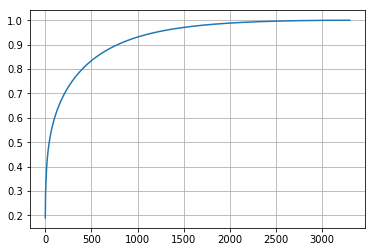

In [83]:
Exp_var = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(Exp_var.size), Exp_var)
plt.grid()

Cool. Cool, cool, cool. It seems it is working so far

In [116]:
# Lets settle for the time being with 500 components. That is perhaps too much, but lets see
# We make here the pipe for the analysis, here only with 500 channels (just to see what happens)
pca_pipe_n500 = Pipeline([('scaler',StandardScaler()), ('pca',PCA(n_components=500))])
pca_pipe_n500.fit(X_train)

X_pca500_train = pca_pipe_n500.transform(X_train)
X_pca500_test = pca_pipe_n500.transform(X_test)

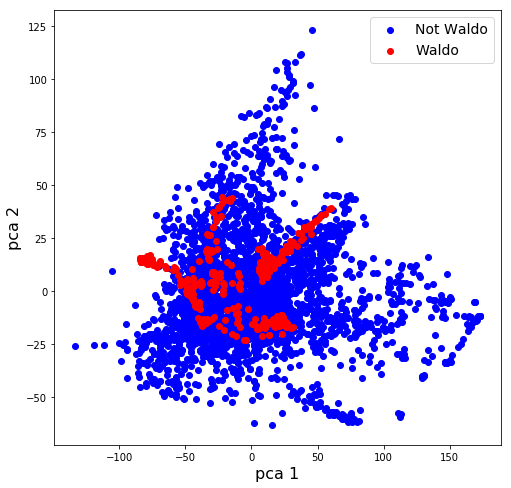

In [117]:
plt.figure(figsize = (8,8))

plt.scatter(X_pca500_train[y_train==0,0],X_pca500_train[y_train==0,1],c='blue',label='Not Waldo')
plt.scatter(X_pca500_train[y_train==1,0],X_pca500_train[y_train==1,1],c='red',label='Waldo')

plt.legend(fontsize=14)
plt.xlabel("pca 1",fontsize=16)
plt.ylabel("pca 2",fontsize=16)

plt.show()

In [118]:
print(type(X_pca500_train),type(X_pca500_test))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


So, we have found a crucial mistake in Chopain solution... OVERFITTING  
However, we can still pursue the solution path

In [126]:
# Now we can proceed with the Knn algorithm and check results
# The number of K-Neighbors is sampled
# Save a list of Knn fits, Knn predictions of the test set and scores
Knn_fits_u = []
Knn_pred_u = []
Knn_scor_u = []

for i in range(1,11):
    knn_pca_u = KNeighborsClassifier(n_neighbors=i, weights='uniform', n_jobs=-1)
    knn_pca_u.fit(X_pca500_train, y_train)
    Train_score = knn_pca_u.score(X_pca500_train, y_train)
    Test_score = knn_pca_u.score(X_pca500_test, y_test)
    Knn_fits_u.append(knn_pca_u)
    Knn_pred_u.append(knn_pca_u.predict(X_pca500_test))
    Knn_scor_u.append([i, Train_score, Test_score])
    print(i, Train_score, Test_score)


1 1.0 0.9827272727272728
2 0.9848484848484849 0.9645454545454546
3 0.9818181818181818 0.9654545454545455
4 0.9709090909090909 0.9527272727272728
5 0.9709090909090909 0.9518181818181818
6 0.9593939393939394 0.9427272727272727
7 0.9587878787878787 0.9418181818181818
8 0.9466666666666667 0.9390909090909091
9 0.9493939393939393 0.9381818181818182
10 0.9415151515151515 0.9290909090909091


In [127]:
# Now we can proceed with the Knn algorithm and check results
# The number of K-Neighbors is sampled
# Save a list of Knn fits, Knn predictions of the test set and scores
Knn_fits_d = []
Knn_pred_d = []
Knn_scor_d = []

for i in range(1,11):
    knn_pca_d = KNeighborsClassifier(n_neighbors=i, weights='distance', n_jobs=-1)
    knn_pca_d.fit(X_pca500_train, y_train)
    Train_score = knn_pca_d.score(X_pca500_train, y_train)
    Test_score = knn_pca_d.score(X_pca500_test, y_test)
    Knn_fits_d.append(knn_pca_d)
    Knn_pred_d.append(knn_pca_d.predict(X_pca500_test))
    Knn_scor_d.append([i, Train_score, Test_score])
    print(i, Train_score, Test_score)


1 1.0 0.9827272727272728
2 1.0 0.9827272727272728
3 1.0 0.9718181818181818
4 1.0 0.9654545454545455
5 1.0 0.9554545454545454
6 1.0 0.9509090909090909
7 1.0 0.9436363636363636
8 1.0 0.9454545454545454
9 1.0 0.9409090909090909
10 1.0 0.9418181818181818


In [129]:
confusion_matrix(y_test, Knn_pred_d[0])

array([[988,   6],
       [ 13,  93]], dtype=int64)

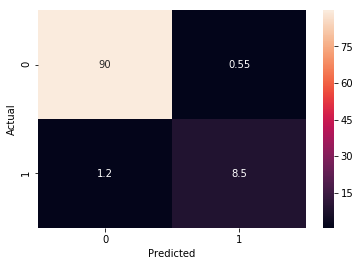

In [138]:
Knn_d1 = {'y_Actual':y_test,'y_Predicted':Knn_pred_d[0]}
Knnd_df = pd.DataFrame(Knn_d1, columns=['y_Actual','y_Predicted'])

cm = pd.crosstab(Knnd_df['y_Actual'], Knnd_df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
cm = 100*cm/len(y_test)
sns.heatmap(cm, annot=True)
plt.show()

In [142]:
# Now for the uniform one
confusion_matrix(y_test, Knn_pred_u[2])

array([[987,   7],
       [ 31,  75]], dtype=int64)

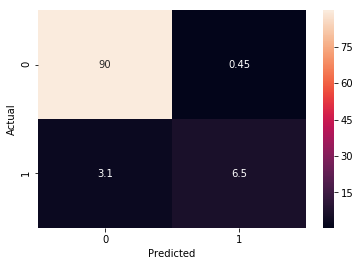

In [143]:
Knn_u2 = {'y_Actual':y_test,'y_Predicted':Knn_pred_u[1]}
Knnu_df = pd.DataFrame(Knn_u2, columns=['y_Actual','y_Predicted'])

cm = pd.crosstab(Knnu_df['y_Actual'], Knnu_df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
cm = 100*cm/len(y_test)
sns.heatmap(cm, annot=True)
plt.show()

It appears to be clear that ONE single neighbor does the trick here

Ok, in principle it would be easy to apply other classification methods to the DataFrames. For the moment it would be better to explore other measures for the images

### Image measures and moments

Lets start by calculating the percentages of dominant channels for each channel

In [148]:
#NOTE: It might be better to save Figures using
# plt.imsave("Name", figure_array)

In [166]:
W_Dom_Red_pct = []
W_Dom_Green_pct = []
W_Dom_Blue_pct = []

for image in Waldo_train:
    W_Dom_Red_pct.append(Redpct(image))
    W_Dom_Green_pct.append(Greenpct(image))
    W_Dom_Blue_pct.append(Bluepct(image))

dic = {"Dom_Red_pct":W_Dom_Red_pct, "Dom_Green_pct":W_Dom_Green_pct,"Dom_Blue_pct":W_Dom_Blue_pct}
Waldo_feats_df = pd.DataFrame(data=dic)
Waldo_feats_df.head()

Dom_Red_pct  Dom_Green_pct  Dom_Blue_pct
0     0.652588       0.093262      0.254150
1     0.764160       0.089355      0.146484
2     0.763672       0.093994      0.142334
3     0.628174       0.093994      0.277832
4     0.792725       0.091797      0.115479

In [165]:
NW_Dom_Red_pct = []
NW_Dom_Green_pct = []
NW_Dom_Blue_pct = []

for image in NW_train:
    NW_Dom_Red_pct.append(Redpct(image))
    NW_Dom_Green_pct.append(Greenpct(image))
    NW_Dom_Blue_pct.append(Bluepct(image))

dic = {"Dom_Red_pct":NW_Dom_Red_pct, "Dom_Green_pct":NW_Dom_Green_pct,"Dom_Blue_pct":NW_Dom_Blue_pct}
NW_feats_df = pd.DataFrame(data=dic)
NW_feats_df.head()

Dom_Red_pct  Dom_Green_pct  Dom_Blue_pct
0     0.765137       0.053223      0.181641
1     0.972168       0.018555      0.009277
2     0.828125       0.064453      0.107422
3     0.903809       0.068848      0.027344
4     0.864502       0.091064      0.044434

In [286]:
# Lets now use histograms and derived measures
Waldo_moments = []
Waldo_Hu = []

for image in Waldo_train:
    Moments = [cv2.moments(image[:,:,0]),
              cv2.moments(image[:,:,1]),
              cv2.moments(image[:,:,2])]    
    HuMoments = [cv2.HuMoments(Moments[0]),
                 cv2.HuMoments(Moments[1]),
                 cv2.HuMoments(Moments[2])]
    for i in range(0,3):
        temp = HuMoments[i]
        for j in range(0,7):
            temp = HuMoments[i][j]
            HuMoments[i][j] = -np.sign(temp)* np.log10(abs(temp))
    Waldo_moments.append(Moments)
    Waldo_Hu.append(HuMoments)


m00_R_l, m00_G_l, m00_B_l = [],[],[]
m01_R_l, m01_G_l, m01_B_l = [],[],[]
m02_R_l, m02_G_l, m02_B_l = [],[],[]
m03_R_l, m03_G_l, m03_B_l = [],[],[]
m10_R_l, m10_G_l, m10_B_l = [],[],[]
m11_R_l, m11_G_l, m11_B_l = [],[],[]
m12_R_l, m12_G_l, m12_B_l = [],[],[]
m20_R_l, m20_G_l, m20_B_l = [],[],[]
m21_R_l, m21_G_l, m21_B_l = [],[],[]
m30_R_l, m30_G_l, m30_B_l = [],[],[]

mu02_R_l, mu02_G_l, mu02_B_l = [],[],[]
mu03_R_l, mu03_G_l, mu03_B_l = [],[],[]
mu11_R_l, mu11_G_l, mu11_B_l = [],[],[]
mu12_R_l, mu12_G_l, mu12_B_l = [],[],[]
mu20_R_l, mu20_G_l, mu20_B_l = [],[],[]
mu21_R_l, mu21_G_l, mu21_B_l = [],[],[]
mu30_R_l, mu30_G_l, mu30_B_l = [],[],[]

nu02_R_l, nu02_G_l, nu02_B_l = [],[],[]
nu03_R_l, nu03_G_l, nu03_B_l = [],[],[]
nu11_R_l, nu11_G_l, nu11_B_l = [],[],[]
nu12_R_l, nu12_G_l, nu12_B_l = [],[],[]
nu20_R_l, nu20_G_l, nu20_B_l = [],[],[]
nu21_R_l, nu21_G_l, nu21_B_l = [],[],[]
nu30_R_l, nu30_G_l, nu30_B_l = [],[],[]

HuR1_l, HuG1_l, HuB1_l = [],[],[]
HuR2_l, HuG2_l, HuB2_l = [],[],[]
HuR3_l, HuG3_l, HuB3_l = [],[],[]
HuR4_l, HuG4_l, HuB4_l = [],[],[]
HuR5_l, HuG5_l, HuB5_l = [],[],[]
HuR6_l, HuG6_l, HuB6_l = [],[],[]
HuR7_l, HuG7_l, HuB7_l = [],[],[]


for i in range(len(Waldo_moments)):
    m00_R_l.append(Waldo_moments[i][0]['m00'])
    m00_G_l.append(Waldo_moments[i][1]['m00'])
    m00_B_l.append(Waldo_moments[i][2]['m00'])
    m01_R_l.append(Waldo_moments[i][0]['m01'])
    m01_G_l.append(Waldo_moments[i][1]['m01'])
    m01_B_l.append(Waldo_moments[i][2]['m01'])
    m02_R_l.append(Waldo_moments[i][0]['m02'])
    m02_G_l.append(Waldo_moments[i][1]['m02'])
    m02_B_l.append(Waldo_moments[i][2]['m02'])
    m03_R_l.append(Waldo_moments[i][0]['m03'])
    m03_G_l.append(Waldo_moments[i][1]['m03'])
    m03_B_l.append(Waldo_moments[i][2]['m03'])
    m10_R_l.append(Waldo_moments[i][0]['m10'])
    m10_G_l.append(Waldo_moments[i][1]['m10'])
    m10_B_l.append(Waldo_moments[i][2]['m10'])
    m11_R_l.append(Waldo_moments[i][0]['m11'])
    m11_G_l.append(Waldo_moments[i][1]['m11'])
    m11_B_l.append(Waldo_moments[i][2]['m11'])
    m12_R_l.append(Waldo_moments[i][0]['m12'])
    m12_G_l.append(Waldo_moments[i][1]['m12'])
    m12_B_l.append(Waldo_moments[i][2]['m12'])
    m20_R_l.append(Waldo_moments[i][0]['m20'])
    m20_G_l.append(Waldo_moments[i][1]['m20'])
    m20_B_l.append(Waldo_moments[i][2]['m20'])
    m21_R_l.append(Waldo_moments[i][0]['m21'])
    m21_G_l.append(Waldo_moments[i][1]['m21'])
    m21_B_l.append(Waldo_moments[i][2]['m21'])
    m30_R_l.append(Waldo_moments[i][0]['m30'])
    m30_G_l.append(Waldo_moments[i][1]['m30'])
    m30_B_l.append(Waldo_moments[i][2]['m30'])

    mu02_R_l.append(Waldo_moments[i][0]['mu02'])
    mu02_G_l.append(Waldo_moments[i][1]['mu02'])
    mu02_B_l.append(Waldo_moments[i][2]['mu02'])
    mu03_R_l.append(Waldo_moments[i][0]['mu03'])
    mu03_G_l.append(Waldo_moments[i][1]['mu03'])
    mu03_B_l.append(Waldo_moments[i][2]['mu03'])
    mu11_R_l.append(Waldo_moments[i][0]['mu11'])
    mu11_G_l.append(Waldo_moments[i][1]['mu11'])
    mu11_B_l.append(Waldo_moments[i][2]['mu11'])
    mu12_R_l.append(Waldo_moments[i][0]['mu12'])
    mu12_G_l.append(Waldo_moments[i][1]['mu12'])
    mu12_B_l.append(Waldo_moments[i][2]['mu12'])
    mu20_R_l.append(Waldo_moments[i][0]['mu20'])
    mu20_G_l.append(Waldo_moments[i][1]['mu20'])
    mu20_B_l.append(Waldo_moments[i][2]['mu20'])
    mu21_R_l.append(Waldo_moments[i][0]['mu21'])
    mu21_G_l.append(Waldo_moments[i][1]['mu21'])
    mu21_B_l.append(Waldo_moments[i][2]['mu21'])
    mu30_R_l.append(Waldo_moments[i][0]['mu30'])
    mu30_G_l.append(Waldo_moments[i][1]['mu30'])
    mu30_B_l.append(Waldo_moments[i][2]['mu30'])

    nu02_R_l.append(Waldo_moments[i][0]['nu02'])
    nu02_G_l.append(Waldo_moments[i][1]['nu02'])
    nu02_B_l.append(Waldo_moments[i][2]['nu02'])
    nu03_R_l.append(Waldo_moments[i][0]['nu03'])
    nu03_G_l.append(Waldo_moments[i][1]['nu03'])
    nu03_B_l.append(Waldo_moments[i][2]['nu03'])
    nu11_R_l.append(Waldo_moments[i][0]['nu11'])
    nu11_G_l.append(Waldo_moments[i][1]['nu11'])
    nu11_B_l.append(Waldo_moments[i][2]['nu11'])
    nu12_R_l.append(Waldo_moments[i][0]['nu12'])
    nu12_G_l.append(Waldo_moments[i][1]['nu12'])
    nu12_B_l.append(Waldo_moments[i][2]['nu12'])
    nu20_R_l.append(Waldo_moments[i][0]['nu20'])
    nu20_G_l.append(Waldo_moments[i][1]['nu20'])
    nu20_B_l.append(Waldo_moments[i][2]['nu20'])
    nu21_R_l.append(Waldo_moments[i][0]['nu21'])
    nu21_G_l.append(Waldo_moments[i][1]['nu21'])
    nu21_B_l.append(Waldo_moments[i][2]['nu21'])
    nu30_R_l.append(Waldo_moments[i][0]['nu30'])
    nu30_G_l.append(Waldo_moments[i][1]['nu30'])
    nu30_B_l.append(Waldo_moments[i][2]['nu30'])

    HuR1_l.append(Waldo_Hu[i][0][0][0])
    HuG1_l.append(Waldo_Hu[i][1][0][0])
    HuB1_l.append(Waldo_Hu[i][2][0][0])
    HuR2_l.append(Waldo_Hu[i][0][1][0])
    HuG2_l.append(Waldo_Hu[i][1][1][0])
    HuB2_l.append(Waldo_Hu[i][2][1][0])
    HuR3_l.append(Waldo_Hu[i][0][2][0])
    HuG3_l.append(Waldo_Hu[i][1][2][0])
    HuB3_l.append(Waldo_Hu[i][2][2][0])
    HuR4_l.append(Waldo_Hu[i][0][3][0])
    HuG4_l.append(Waldo_Hu[i][1][3][0])
    HuB4_l.append(Waldo_Hu[i][2][3][0])
    HuR5_l.append(Waldo_Hu[i][0][4][0])
    HuG5_l.append(Waldo_Hu[i][1][4][0])
    HuB5_l.append(Waldo_Hu[i][2][4][0])
    HuR6_l.append(Waldo_Hu[i][0][5][0])
    HuG6_l.append(Waldo_Hu[i][1][5][0])
    HuB6_l.append(Waldo_Hu[i][2][5][0])
    HuR7_l.append(Waldo_Hu[i][0][6][0])
    HuG7_l.append(Waldo_Hu[i][1][6][0])
    HuB7_l.append(Waldo_Hu[i][2][6][0])



dic = {'m00_R':m00_R_l, 'm00_G':m00_G_l, 'm00_B':m00_B_l,
       'm01_R':m01_R_l, 'm01_G':m01_G_l, 'm01_B':m01_B_l,
       'm02_R':m02_R_l, 'm02_G':m02_G_l, 'm02_B':m02_B_l,
       'm03_R':m03_R_l, 'm03_G':m03_G_l, 'm03_B':m03_B_l,
       'm10_R':m10_R_l, 'm10_G':m10_G_l, 'm10_B':m10_B_l,
       'm11_R':m11_R_l, 'm11_G':m11_G_l, 'm11_B':m11_B_l,
       'm12_R':m12_R_l, 'm12_G':m12_G_l, 'm12_B':m12_B_l,
       'm20_R':m20_R_l, 'm20_G':m20_G_l, 'm20_B':m20_B_l,
       'm21_R':m21_R_l, 'm21_G':m21_G_l, 'm21_B':m21_B_l,
       'm30_R':m30_R_l, 'm30_G':m30_G_l, 'm30_B':m30_B_l,       
       'mu02_R':mu02_R_l, 'mu02_G':mu02_G_l, 'mu02_B':mu02_B_l,
       'mu03_R':mu03_R_l, 'mu03_G':mu03_G_l, 'mu03_B':mu03_B_l,
       'mu11_R':mu11_R_l, 'mu11_G':mu11_G_l, 'mu11_B':mu11_B_l,
       'mu12_R':mu12_R_l, 'mu12_G':mu12_G_l, 'mu12_B':mu12_B_l,
       'mu20_R':mu20_R_l, 'mu20_G':mu20_G_l, 'mu20_B':mu20_B_l,
       'mu21_R':mu21_R_l, 'mu21_G':mu21_G_l, 'mu21_B':mu21_B_l,       
       'mu30_R':mu30_R_l, 'mu30_G':mu30_G_l, 'mu30_B':mu30_B_l,
       'nu02_R':nu02_R_l, 'nu02_G':nu02_G_l, 'nu02_B':nu02_B_l,
       'nu03_R':nu03_R_l, 'nu03_G':nu03_G_l, 'nu03_B':nu03_B_l,
       'nu11_R':nu11_R_l, 'nu11_G':nu11_G_l, 'nu11_B':nu11_B_l,
       'nu12_R':nu12_R_l, 'nu12_G':nu12_G_l, 'nu12_B':nu12_B_l,
       'nu20_R':nu20_R_l, 'nu20_G':nu20_G_l, 'nu20_B':nu20_B_l,
       'nu21_R':nu21_R_l, 'nu21_G':nu21_G_l, 'nu21_B':nu21_B_l,       
       'nu30_R':nu30_R_l, 'nu30_G':nu30_G_l, 'nu30_B':nu30_B_l,
       'Hu_R1':HuR1_l, 'Hu_G1':HuG1_l, 'Hu_B1':HuB1_l,
       'Hu_R2':HuR2_l, 'Hu_G2':HuG2_l, 'Hu_B2':HuB2_l,
       'Hu_R3':HuR3_l, 'Hu_G3':HuG3_l, 'Hu_B3':HuB3_l,
       'Hu_R4':HuR4_l, 'Hu_G4':HuG4_l, 'Hu_B4':HuB4_l,
       'Hu_R5':HuR5_l, 'Hu_G5':HuG5_l, 'Hu_B5':HuB5_l,
       'Hu_R6':HuR6_l, 'Hu_G6':HuG6_l, 'Hu_B6':HuB6_l,
       'Hu_R7':HuR7_l, 'Hu_G7':HuG7_l, 'Hu_B7':HuB7_l,
       }


Waldo_moments_df = pd.DataFrame(data=dic)
Waldo_moments_df.head()

m00_R     m00_G     m00_B       m01_R       m01_G       m01_B  \
0  562776.0  461394.0  382607.0  18138800.0  15424857.0  13639027.0   
1  688026.0  588902.0  265397.0  19546113.0  16848042.0  10006205.0   
2  651908.0  551485.0  277243.0  19102730.0  16195169.0   9899127.0   
3  563067.0  503787.0  392931.0  17974219.0  16710993.0  14066108.0   
4  673054.0  543029.0  262571.0  19869665.0  15594103.0   9062231.0   

         m02_R        m02_G        m02_B         m03_R    ...          Hu_B4  \
0  775775802.0  677082273.0  618883295.0  3.701347e+10    ...      10.342036   
1  805598451.0  699274538.0  458527775.0  3.836533e+10    ...       8.738432   
2  806092576.0  681050005.0  430645187.0  3.869725e+10    ...       8.986413   
3  758159727.0  723354485.0  641071258.0  3.586437e+10    ...      10.098239   
4  835994465.0  651516061.0  397979875.0  4.004752e+10    ...       9.225044   

       Hu_R5      Hu_G5      Hu_B5      Hu_R6      Hu_G6      Hu_B6  \
0  22.617380 -21.236835 -20.600932  15.415605  15.440725 -14.461375   
1  22.145790 -21.969407  17.666240  15.290115  14.521951  12.031884   
2 -23.706359  22.631614  18.093360 -15.243697  14.856095  12.470137   
3  21.635716 -21.525226 -20.293246 -15.178666  15.116494 -14.008210   
4 -23.172704  23.388984  19.549486 -15.920614  16.073709  12.430984   

       Hu_R7      Hu_G7      Hu_B7  
0  21.872239 -21.516259 -21.230398  
1  21.987390  21.657544 -18.477025  
2  22.748738  22.177143  18.898381  
3  22.283056 -21.614498 -20.231106  
4  23.097669 -22.253178  18.416339  

[5 rows x 93 columns]

In [289]:
# OK. Now lets do the same awful thing for the Not Waldo set
NW_moments = []
NW_Hu = []

for image in NW_train:
    Moments = [cv2.moments(image[:,:,0]),
              cv2.moments(image[:,:,1]),
              cv2.moments(image[:,:,2])]    
    HuMoments = [cv2.HuMoments(Moments[0]),
                 cv2.HuMoments(Moments[1]),
                 cv2.HuMoments(Moments[2])]
    for i in range(0,3):
        temp = HuMoments[i]
        for j in range(0,7):
            temp = HuMoments[i][j]
            HuMoments[i][j] = -np.sign(temp)* np.log10(abs(temp))
    NW_moments.append(Moments)
    NW_Hu.append(HuMoments)


m00_R_l, m00_G_l, m00_B_l = [],[],[]
m01_R_l, m01_G_l, m01_B_l = [],[],[]
m02_R_l, m02_G_l, m02_B_l = [],[],[]
m03_R_l, m03_G_l, m03_B_l = [],[],[]
m10_R_l, m10_G_l, m10_B_l = [],[],[]
m11_R_l, m11_G_l, m11_B_l = [],[],[]
m12_R_l, m12_G_l, m12_B_l = [],[],[]
m20_R_l, m20_G_l, m20_B_l = [],[],[]
m21_R_l, m21_G_l, m21_B_l = [],[],[]
m30_R_l, m30_G_l, m30_B_l = [],[],[]

mu02_R_l, mu02_G_l, mu02_B_l = [],[],[]
mu03_R_l, mu03_G_l, mu03_B_l = [],[],[]
mu11_R_l, mu11_G_l, mu11_B_l = [],[],[]
mu12_R_l, mu12_G_l, mu12_B_l = [],[],[]
mu20_R_l, mu20_G_l, mu20_B_l = [],[],[]
mu21_R_l, mu21_G_l, mu21_B_l = [],[],[]
mu30_R_l, mu30_G_l, mu30_B_l = [],[],[]

nu02_R_l, nu02_G_l, nu02_B_l = [],[],[]
nu03_R_l, nu03_G_l, nu03_B_l = [],[],[]
nu11_R_l, nu11_G_l, nu11_B_l = [],[],[]
nu12_R_l, nu12_G_l, nu12_B_l = [],[],[]
nu20_R_l, nu20_G_l, nu20_B_l = [],[],[]
nu21_R_l, nu21_G_l, nu21_B_l = [],[],[]
nu30_R_l, nu30_G_l, nu30_B_l = [],[],[]

HuR1_l, HuG1_l, HuB1_l = [],[],[]
HuR2_l, HuG2_l, HuB2_l = [],[],[]
HuR3_l, HuG3_l, HuB3_l = [],[],[]
HuR4_l, HuG4_l, HuB4_l = [],[],[]
HuR5_l, HuG5_l, HuB5_l = [],[],[]
HuR6_l, HuG6_l, HuB6_l = [],[],[]
HuR7_l, HuG7_l, HuB7_l = [],[],[]


for i in range(len(NW_moments)):
    m00_R_l.append(NW_moments[i][0]['m00'])
    m00_G_l.append(NW_moments[i][1]['m00'])
    m00_B_l.append(NW_moments[i][2]['m00'])
    m01_R_l.append(NW_moments[i][0]['m01'])
    m01_G_l.append(NW_moments[i][1]['m01'])
    m01_B_l.append(NW_moments[i][2]['m01'])
    m02_R_l.append(NW_moments[i][0]['m02'])
    m02_G_l.append(NW_moments[i][1]['m02'])
    m02_B_l.append(NW_moments[i][2]['m02'])
    m03_R_l.append(NW_moments[i][0]['m03'])
    m03_G_l.append(NW_moments[i][1]['m03'])
    m03_B_l.append(NW_moments[i][2]['m03'])
    m10_R_l.append(NW_moments[i][0]['m10'])
    m10_G_l.append(NW_moments[i][1]['m10'])
    m10_B_l.append(NW_moments[i][2]['m10'])
    m11_R_l.append(NW_moments[i][0]['m11'])
    m11_G_l.append(NW_moments[i][1]['m11'])
    m11_B_l.append(NW_moments[i][2]['m11'])
    m12_R_l.append(NW_moments[i][0]['m12'])
    m12_G_l.append(NW_moments[i][1]['m12'])
    m12_B_l.append(NW_moments[i][2]['m12'])
    m20_R_l.append(NW_moments[i][0]['m20'])
    m20_G_l.append(NW_moments[i][1]['m20'])
    m20_B_l.append(NW_moments[i][2]['m20'])
    m21_R_l.append(NW_moments[i][0]['m21'])
    m21_G_l.append(NW_moments[i][1]['m21'])
    m21_B_l.append(NW_moments[i][2]['m21'])
    m30_R_l.append(NW_moments[i][0]['m30'])
    m30_G_l.append(NW_moments[i][1]['m30'])
    m30_B_l.append(NW_moments[i][2]['m30'])

    mu02_R_l.append(NW_moments[i][0]['mu02'])
    mu02_G_l.append(NW_moments[i][1]['mu02'])
    mu02_B_l.append(NW_moments[i][2]['mu02'])
    mu03_R_l.append(NW_moments[i][0]['mu03'])
    mu03_G_l.append(NW_moments[i][1]['mu03'])
    mu03_B_l.append(NW_moments[i][2]['mu03'])
    mu11_R_l.append(NW_moments[i][0]['mu11'])
    mu11_G_l.append(NW_moments[i][1]['mu11'])
    mu11_B_l.append(NW_moments[i][2]['mu11'])
    mu12_R_l.append(NW_moments[i][0]['mu12'])
    mu12_G_l.append(NW_moments[i][1]['mu12'])
    mu12_B_l.append(NW_moments[i][2]['mu12'])
    mu20_R_l.append(NW_moments[i][0]['mu20'])
    mu20_G_l.append(NW_moments[i][1]['mu20'])
    mu20_B_l.append(NW_moments[i][2]['mu20'])
    mu21_R_l.append(NW_moments[i][0]['mu21'])
    mu21_G_l.append(NW_moments[i][1]['mu21'])
    mu21_B_l.append(NW_moments[i][2]['mu21'])
    mu30_R_l.append(NW_moments[i][0]['mu30'])
    mu30_G_l.append(NW_moments[i][1]['mu30'])
    mu30_B_l.append(NW_moments[i][2]['mu30'])

    nu02_R_l.append(NW_moments[i][0]['nu02'])
    nu02_G_l.append(NW_moments[i][1]['nu02'])
    nu02_B_l.append(NW_moments[i][2]['nu02'])
    nu03_R_l.append(NW_moments[i][0]['nu03'])
    nu03_G_l.append(NW_moments[i][1]['nu03'])
    nu03_B_l.append(NW_moments[i][2]['nu03'])
    nu11_R_l.append(NW_moments[i][0]['nu11'])
    nu11_G_l.append(NW_moments[i][1]['nu11'])
    nu11_B_l.append(NW_moments[i][2]['nu11'])
    nu12_R_l.append(NW_moments[i][0]['nu12'])
    nu12_G_l.append(NW_moments[i][1]['nu12'])
    nu12_B_l.append(NW_moments[i][2]['nu12'])
    nu20_R_l.append(NW_moments[i][0]['nu20'])
    nu20_G_l.append(NW_moments[i][1]['nu20'])
    nu20_B_l.append(NW_moments[i][2]['nu20'])
    nu21_R_l.append(NW_moments[i][0]['nu21'])
    nu21_G_l.append(NW_moments[i][1]['nu21'])
    nu21_B_l.append(NW_moments[i][2]['nu21'])
    nu30_R_l.append(NW_moments[i][0]['nu30'])
    nu30_G_l.append(NW_moments[i][1]['nu30'])
    nu30_B_l.append(NW_moments[i][2]['nu30'])

    HuR1_l.append(NW_Hu[i][0][0][0])
    HuG1_l.append(NW_Hu[i][1][0][0])
    HuB1_l.append(NW_Hu[i][2][0][0])
    HuR2_l.append(NW_Hu[i][0][1][0])
    HuG2_l.append(NW_Hu[i][1][1][0])
    HuB2_l.append(NW_Hu[i][2][1][0])
    HuR3_l.append(NW_Hu[i][0][2][0])
    HuG3_l.append(NW_Hu[i][1][2][0])
    HuB3_l.append(NW_Hu[i][2][2][0])
    HuR4_l.append(NW_Hu[i][0][3][0])
    HuG4_l.append(NW_Hu[i][1][3][0])
    HuB4_l.append(NW_Hu[i][2][3][0])
    HuR5_l.append(NW_Hu[i][0][4][0])
    HuG5_l.append(NW_Hu[i][1][4][0])
    HuB5_l.append(NW_Hu[i][2][4][0])
    HuR6_l.append(NW_Hu[i][0][5][0])
    HuG6_l.append(NW_Hu[i][1][5][0])
    HuB6_l.append(NW_Hu[i][2][5][0])
    HuR7_l.append(NW_Hu[i][0][6][0])
    HuG7_l.append(NW_Hu[i][1][6][0])
    HuB7_l.append(NW_Hu[i][2][6][0])



dic = {'m00_R':m00_R_l, 'm00_G':m00_G_l, 'm00_B':m00_B_l,
       'm01_R':m01_R_l, 'm01_G':m01_G_l, 'm01_B':m01_B_l,
       'm02_R':m02_R_l, 'm02_G':m02_G_l, 'm02_B':m02_B_l,
       'm03_R':m03_R_l, 'm03_G':m03_G_l, 'm03_B':m03_B_l,
       'm10_R':m10_R_l, 'm10_G':m10_G_l, 'm10_B':m10_B_l,
       'm11_R':m11_R_l, 'm11_G':m11_G_l, 'm11_B':m11_B_l,
       'm12_R':m12_R_l, 'm12_G':m12_G_l, 'm12_B':m12_B_l,
       'm20_R':m20_R_l, 'm20_G':m20_G_l, 'm20_B':m20_B_l,
       'm21_R':m21_R_l, 'm21_G':m21_G_l, 'm21_B':m21_B_l,
       'm30_R':m30_R_l, 'm30_G':m30_G_l, 'm30_B':m30_B_l,       
       'mu02_R':mu02_R_l, 'mu02_G':mu02_G_l, 'mu02_B':mu02_B_l,
       'mu03_R':mu03_R_l, 'mu03_G':mu03_G_l, 'mu03_B':mu03_B_l,
       'mu11_R':mu11_R_l, 'mu11_G':mu11_G_l, 'mu11_B':mu11_B_l,
       'mu12_R':mu12_R_l, 'mu12_G':mu12_G_l, 'mu12_B':mu12_B_l,
       'mu20_R':mu20_R_l, 'mu20_G':mu20_G_l, 'mu20_B':mu20_B_l,
       'mu21_R':mu21_R_l, 'mu21_G':mu21_G_l, 'mu21_B':mu21_B_l,       
       'mu30_R':mu30_R_l, 'mu30_G':mu30_G_l, 'mu30_B':mu30_B_l,
       'nu02_R':nu02_R_l, 'nu02_G':nu02_G_l, 'nu02_B':nu02_B_l,
       'nu03_R':nu03_R_l, 'nu03_G':nu03_G_l, 'nu03_B':nu03_B_l,
       'nu11_R':nu11_R_l, 'nu11_G':nu11_G_l, 'nu11_B':nu11_B_l,
       'nu12_R':nu12_R_l, 'nu12_G':nu12_G_l, 'nu12_B':nu12_B_l,
       'nu20_R':nu20_R_l, 'nu20_G':nu20_G_l, 'nu20_B':nu20_B_l,
       'nu21_R':nu21_R_l, 'nu21_G':nu21_G_l, 'nu21_B':nu21_B_l,       
       'nu30_R':nu30_R_l, 'nu30_G':nu30_G_l, 'nu30_B':nu30_B_l,
       'Hu_R1':HuR1_l, 'Hu_G1':HuG1_l, 'Hu_B1':HuB1_l,
       'Hu_R2':HuR2_l, 'Hu_G2':HuG2_l, 'Hu_B2':HuB2_l,
       'Hu_R3':HuR3_l, 'Hu_G3':HuG3_l, 'Hu_B3':HuB3_l,
       'Hu_R4':HuR4_l, 'Hu_G4':HuG4_l, 'Hu_B4':HuB4_l,
       'Hu_R5':HuR5_l, 'Hu_G5':HuG5_l, 'Hu_B5':HuB5_l,
       'Hu_R6':HuR6_l, 'Hu_G6':HuG6_l, 'Hu_B6':HuB6_l,
       'Hu_R7':HuR7_l, 'Hu_G7':HuG7_l, 'Hu_B7':HuB7_l,
       }


NW_moments_df = pd.DataFrame(data=dic)
NW_moments_df.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in multiply
  app.launch_new_instance()


m00_R     m00_G     m00_B       m01_R       m01_G      m01_B  \
0  692150.0  583675.0  351940.0  22792499.0  18088957.0  9977743.0   
1  864649.0  734961.0  211545.0  29443665.0  26074936.0  4923711.0   
2  651271.0  533801.0  305468.0  20014854.0  16696418.0  9501835.0   
3  714145.0  543957.0  216753.0  24565013.0  20559917.0  6139269.0   
4  726607.0  385889.0  224931.0  23890760.0  10618924.0  6828304.0   

          m02_R         m02_G        m02_B         m03_R    ...      \
0  9.683725e+08  7.396410e+08  386964329.0  4.561944e+10    ...       
1  1.306218e+09  1.179932e+09  178001253.0  6.388642e+10    ...       
2  8.404970e+08  7.019284e+08  399696191.0  3.999108e+10    ...       
3  1.085976e+09  9.464286e+08  248357619.0  5.299589e+10    ...       
4  1.034681e+09  4.161761e+08  283595748.0  4.995947e+10    ...       

       Hu_B4      Hu_R5      Hu_G5      Hu_B5      Hu_R6      Hu_G6  \
0  10.233882 -23.553431  21.572832  20.711240 -15.831081  15.257543   
1   9.241928  22.993015  21.921479  18.080319  16.108344  15.570594   
2  10.833863 -23.362082  21.144628  22.036980 -15.632709 -15.092482   
3   9.353445  22.694105 -20.407300  18.611530  14.970170  14.005905   
4   9.383923  24.156493  20.215773  19.599722  16.899424  14.490454   

       Hu_B6      Hu_R7      Hu_G7      Hu_B7  
0  13.832656 -23.420924 -22.366157  24.022116  
1 -12.437057  23.527096  21.892404 -19.297260  
2 -14.379768 -22.707335 -21.121001  21.820628  
3  12.655948 -22.574441 -20.670597  20.320234  
4  12.973249 -24.406410  20.703021  19.080023  

[5 rows x 93 columns]

### FINALLY!!!! Now we can do PCA and KNN on this new data set
For this we should join the different dataframes that have been created. 